# Testing with CATBoost

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import f1_score
sns.set_theme()
from catboost import CatBoostClassifier
import scipy
from scipy import signal

import sys; sys.path.append("../../")
from modules.utils import load_yaml
from modules.evaluation import pretty_classification_report, plot_confusion_matrix

/home/stefano/botu/aichallenge-2022/notebooks/fede/env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Read Data

Note: in the submission, we cannot use `test.csv`. This has no labels and it is for submission only. So we need to use validation data as the test

--> This should be OK since the data size seems large enough

In [2]:
TRAIN_CONFIG_PATH = '../../config/train_config.yaml'
DATA_PATH = '../../data/01_split/'

config = load_yaml(TRAIN_CONFIG_PATH)
LABEL_ENCODING = config['LABEL_ENCODING']

train_df = pd.read_csv(os.path.join(DATA_PATH, 'train.csv'))
valid_df = pd.read_csv(os.path.join(DATA_PATH, 'valid.csv'))

encoding_to_label = {v: k for k, v in LABEL_ENCODING.items()}
labels = [key for key in LABEL_ENCODING.keys()]


../../config/train_config.yaml


## Split into train and test

As said, we will use val and test as the same 

In [4]:
train_X, train_y = train_df.loc[:,train_df.columns!='leaktype'], train_df['leaktype']
valid_X, valid_y = valid_df.loc[:,train_df.columns!='leaktype'], valid_df['leaktype']

train_y = train_y.replace(LABEL_ENCODING)
valid_y = valid_y.replace(LABEL_ENCODING)

# Same testing and validation
test_X, test_y = valid_X, valid_y

# Imbalanced learning
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(class_weight='balanced', classes=np.arange(5), y=train_y)

In [12]:
# !pip install --upgrade scipy

Requirement already up-to-date: scipy in ./env/lib/python3.8/site-packages (1.8.1)


In [31]:
# from tsfresh import extract_features
# from tsfresh import extract_features, extract_relevant_features, select_features

# x_inverse = scipy.fft.ifft(train_X.to_numpy()).real


In [149]:
# from pyts.transformation import ROCKET

# rocket = ROCKET()

# rocket.fit(train_X)

# res_ = rocket.transform(train_X)

In [128]:
# import scipy.stats
# impor tmatplotlib.pyplotasplt

class Fea_Extra():
    def __init__(self,Signal,Fs=10):
        self.signal=Signal
        self.Fs=Fs

    def Time_fea(self,signal_):
        """
        Extract11typesoftimedomainfeatures
        """
        N=len(signal_)
        y=signal_
        t_mean_1=np.mean(y)#1_mean(averageamplitude)
        t_std_2=np.std(y,ddof=1)#2_standarddeviation
        t_fgf_3=((np.mean(np.sqrt(np.abs(y)))))**2#3_squarerootamplitude
        t_rms_4=np.sqrt((np.mean(y**2)))#4_RMSrms
        t_pp_5=0.5*(np.max(y)-np.min(y))#5_peak(refertoDr.ZhouHongtiseniorsisterapprenticethesis)
        #t_skew_6=np.sum((t_mean_1)**3)/((N-1)*(t_std_3)**3)
        t_skew_6=scipy.stats.skew(y)#6_skewness
        #t_kur_7=np.sum((y-t_mean_1)**4)/((N-1)*(t_std_3)**4)
        t_kur_7=scipy.stats.kurtosis(y)#7_kurtosis
        t_cres_8=np.max(np.abs(y))/t_rms_4#8_CrestFactor
        t_clear_9=np.max(np.abs(y))/t_fgf_3#9_clearancefactor
        t_shape_10=(N*t_rms_4)/(np.sum(np.abs(y)))#10_Shapefator
        t_imp_11=(np.max(np.abs(y)))/(np.mean(np.abs(y)))#11_ImpulseFator
        t_fea=np.array([t_mean_1,t_std_2,t_fgf_3,t_rms_4,t_pp_5,
        t_skew_6,t_kur_7,t_cres_8,t_clear_9,t_shape_10,t_imp_11])
        return t_fea

    def Fre_fea(self,signal_):
        """
        Extract13typesoffrequencydomainfeatures
        :paramsignal_:
        :return:
        """
        L=len(signal_)
        PL=abs(np.fft.fft(signal_/L))[:int(L/2)]
        PL[0]=0
        F=np.fft.fftfreq(L,.1/self.Fs)[:int(L/2)]
        x=F
        y=PL
        K=len(y)
        f_12=np.mean(y)
        f_13=np.var(y)
        f_14=(np.sum((y-f_12)**3))/(K*((np.sqrt(f_13))**3))
        f_15=(np.sum((y-f_12)**4))/(K*((f_13)**2))
        f_16=(np.sum(x*y))/(np.sum(y))
        f_17=np.sqrt((np.mean(((x-f_16)**2)*(y))))
        f_18=np.sqrt((np.sum((x**2)*y))/(np.sum(y)))
        f_19=np.sqrt((np.sum((x**4)*y))/(np.sum((x**2)*y)))
        f_20=(np.sum((x**2)*y))/(np.sqrt((np.sum(y))*(np.sum((x**4)*y))))
        f_21=f_17/f_16
        f_22=(np.sum(((x-f_16)**3)*y))/(K*(f_17**3))
        f_23=(np.sum(((x-f_16)**4)*y))/(K*(f_17**4))
        f_fea=np.array([f_12,f_13,f_14,f_15,f_16,f_17,f_18,f_19,f_20,f_21,f_22,f_23])
        return f_fea

In [129]:
from tqdm.auto import tqdm

def get_features(x_inverse, freq_feature_spacing=10):
    freq_class = Fea_Extra(x_inverse, freq_feature_spacing) # may need to fix
    feats = []
    for x in tqdm(x_inverse):
        # print(x.type)
        time_fea = freq_class.Time_fea(x)[None]
        freq_fea = freq_class.Fre_fea(x)[None]
        feat_ = np.concatenate([time_fea, freq_fea], axis=1)
        feats.append(feat_)
    feats = np.concatenate(feats, axis=0)
    return feats

In [133]:
from scipy.stats import kurtosis, skew, entropy, differential_entropy


def add_frequency_features(x):
    feats = [x]

    x_inverse = scipy.fft.ifft(x).real
    # x_inverse = scipy.fft.irfft(x)[:, :513]
    feats.append(x_inverse)

    feats.append(get_features(x_inverse))

    # feats.append(kurtosis(x_inverse, axis=1)[:,None])
    # feats.append(skew(x_inverse, axis=1)[:,None])
    # # # feats.append(entropy(x_inverse, axis=1)[:,None])
    # # # feats.append(differential_entropy(x_inverse, axis=1)[:,None])
    # feats.append(np.max(x_inverse, axis=1)[:,None])
    # feats.append(np.min(x_inverse, axis=1)[:,None])
    # feats.append(np.std(x_inverse, axis=1)[:,None])
    # feats.append(np.mean(x_inverse, axis=1)[:,None])
    # feats.append(np.median(x_inverse, axis=1)[:,None])

    # x_inverse = scipy.fft.ifft(x)
    # czt  = scipy.signal.czt(x_inverse)[:, :256]
    # feats.append(czt.real)
    # feats.append(czt.imag)
        
    return np.concatenate(feats, -1)

In [134]:
x_train_new = add_frequency_features(train_X.to_numpy())
x_valid_new = add_frequency_features(valid_X.to_numpy())
x_test_new = x_valid_new

100%|██████████| 6720/6720 [00:03<00:00, 2120.98it/s]


# Train Models

<!-- Tricks: we can use custom parameters to maximize the F1 score -->

Learning rate set to 0.080175
0:	learn: 0.4554244	test: 0.3636919	best: 0.3636919 (0)	total: 26.5ms	remaining: 2m 12s
200:	learn: 0.8554152	test: 0.6820482	best: 0.6826410 (199)	total: 2.97s	remaining: 1m 10s
400:	learn: 0.9423944	test: 0.7819312	best: 0.7821467 (397)	total: 5.85s	remaining: 1m 7s
600:	learn: 0.9701739	test: 0.8219471	best: 0.8219471 (600)	total: 8.72s	remaining: 1m 3s
800:	learn: 0.9821709	test: 0.8373760	best: 0.8394114 (788)	total: 11.6s	remaining: 1m
1000:	learn: 0.9880201	test: 0.8487198	best: 0.8506171 (974)	total: 14.4s	remaining: 57.5s
1200:	learn: 0.9917553	test: 0.8539269	best: 0.8555218 (1195)	total: 17.2s	remaining: 54.5s
1400:	learn: 0.9938441	test: 0.8566023	best: 0.8568216 (1291)	total: 20s	remaining: 51.4s
1600:	learn: 0.9954260	test: 0.8596907	best: 0.8623419 (1548)	total: 22.8s	remaining: 48.5s
1800:	learn: 0.9966582	test: 0.8606741	best: 0.8631930 (1759)	total: 25.7s	remaining: 45.6s
2000:	learn: 0.9973051	test: 0.8627340	best: 0.8655061 (1980)	total

,precision,recall,f1-score,support
0,0.934982,0.925822,0.930380,1429
1,0.944609,0.920039,0.932162,1038
2,0.985467,0.982994,0.984229,3587
3,0.737127,0.850000,0.789550,320
4,0.795389,0.797688,0.796537,346
accuracy,0.945238,0.945238,0.945238,0
macro avg,0.879515,0.895309,0.886572,6720
weighted avg,0.946808,0.945238,0.945801,6720


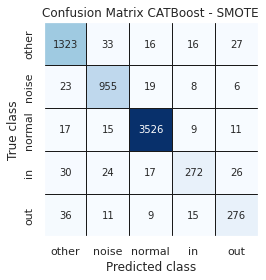

In [136]:
MODEL_NAME = 'CATBoost - SMOTE'

from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state = 42)
X_oversample, y_oversample = smote.fit_resample(x_train_new, train_y)

clf = CatBoostClassifier(
    iterations=5000,
    verbose=200,
    objective='MultiClass',
    eval_metric = 'TotalF1',
    custom_metric='TotalF1',
    task_type="GPU",
    # depth=9,
    devices='2:3',
    # learning_rate=0.3
    class_weights=class_weights
)


clf.fit(
    # x_train_new, train_y,
    X_oversample, y_oversample,
    # cat_features=labels,
    eval_set=(x_valid_new, valid_y),
)

pred_y = clf.predict(x_test_new)
model_name, y_hat = MODEL_NAME, pred_y
plot_confusion_matrix(test_y, y_hat, labels,  f'Confusion Matrix {model_name}')
print('F1 score : {:.3f}'.format(f1_score(test_y, y_hat, average='macro')))
pretty_classification_report(test_y, y_hat)

## Train on all available data

100%|██████████| 33600/33600 [00:15<00:00, 2120.65it/s]


Learning rate set to 0.08199
0:	learn: 0.5483392	test: 0.4750865	best: 0.4750865 (0)	total: 139ms	remaining: 11m 33s
200:	learn: 0.9815197	test: 0.9491617	best: 0.9491617 (200)	total: 16.4s	remaining: 6m 31s
400:	learn: 0.9955863	test: 0.9864615	best: 0.9864615 (400)	total: 31.5s	remaining: 6m
600:	learn: 0.9981683	test: 0.9936904	best: 0.9936904 (600)	total: 45.4s	remaining: 5m 32s
800:	learn: 0.9991474	test: 0.9966372	best: 0.9967806 (768)	total: 58.9s	remaining: 5m 8s
1000:	learn: 0.9996072	test: 0.9983651	best: 0.9983651 (998)	total: 1m 12s	remaining: 4m 49s
1200:	learn: 0.9998352	test: 0.9994690	best: 0.9994690 (1194)	total: 1m 25s	remaining: 4m 31s
1400:	learn: 0.9999001	test: 0.9997461	best: 0.9997461 (1329)	total: 1m 39s	remaining: 4m 14s
1600:	learn: 0.9999539	test: 0.9998569	best: 0.9998569 (1425)	total: 1m 52s	remaining: 3m 59s
1800:	learn: 0.9999837	test: 1.0000000	best: 1.0000000 (1784)	total: 2m 6s	remaining: 3m 44s
2000:	learn: 0.9999898	test: 1.0000000	best: 1.0000000 (

,precision,recall,f1-score,support
0,1.000000,1.000000,1.000000,1415
1,1.000000,1.000000,1.000000,1011
2,1.000000,1.000000,1.000000,3578
3,1.000000,1.000000,1.000000,369
4,1.000000,1.000000,1.000000,347
accuracy,1.000000,1.000000,1.000000,1
macro avg,1.000000,1.000000,1.000000,6720
weighted avg,1.000000,1.000000,1.000000,6720


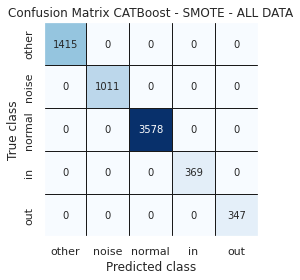

In [137]:
MODEL_NAME = 'CATBoost - SMOTE - ALL DATA'

from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state = 42)

total_train_X, total_train_y =  pd.concat([train_X, valid_X], ignore_index=True), pd.concat([train_y, valid_y], ignore_index=True)

# Add features in frequency domain
total_train_X = add_frequency_features(total_train_X.to_numpy())

X_oversample, y_oversample = smote.fit_resample(total_train_X, total_train_y)

clf = CatBoostClassifier(
    iterations=5000,
    verbose=200,
    objective='MultiClass',
    eval_metric = 'TotalF1',
    custom_metric='TotalF1',
    task_type="GPU",
    depth=10,
    devices='2:3',
    class_weights=class_weights
)

clf.fit(
    X_oversample, y_oversample,
    # cat_features=labels,
    eval_set=(x_valid_new, valid_y),
)

pred_y = clf.predict(x_test_new)
model_name, y_hat = MODEL_NAME, pred_y
plot_confusion_matrix(test_y, y_hat, labels,  f'Confusion Matrix {model_name}')
print('F1 score : {:.3f}'.format(f1_score(test_y, y_hat, average='macro')))
pretty_classification_report(test_y, y_hat)

## Actual test for submission

## New test

Here we transform test data so that it matches the format of the new model with new features

In [138]:
# Setup
model = clf
LABEL_DECODING = {y:x for x,y in LABEL_ENCODING.items()}
RESULTS_PATH = '.'
DATA_DIR = '../../data/01_split'
SAMPLE_DIR = '../../data/sample_submission.csv'


test_df = pd.read_csv(os.path.join(DATA_DIR,'test.csv'))
test_X = test_df.loc[:,test_df.columns!='id']
test_ids = test_df['id']



# Make predictions
sample_df = pd.read_csv(SAMPLE_DIR)
sorter = list(sample_df['id'])


new_test_x = add_frequency_features(test_X.to_numpy())
y_pred = model.predict(new_test_x)
y_pred_df = pd.DataFrame(y_pred, columns=['leaktype'])
y_pred_df['leaktype'] = y_pred_df['leaktype'].replace(LABEL_DECODING)
pred_df = pd.concat([test_ids, y_pred_df],axis=1)

# sort predictions
resdf = pred_df.set_index('id')
result = resdf.loc[sorter].reset_index()
resultpath = os.path.join(RESULTS_PATH, 'predictions.csv')
result.to_csv(resultpath, index=False)

100%|██████████| 7820/7820 [00:03<00:00, 2121.72it/s]


## Old test

In [139]:
# # Setup
# model = clf
# LABEL_DECODING = {y:x for x,y in LABEL_ENCODING.items()}
# RESULTS_PATH = '.'
# DATA_DIR = '../../data/01_split'
# SAMPLE_DIR = '../../data/sample_submission.csv'


# test_df = pd.read_csv(os.path.join(DATA_DIR,'test.csv'))
# test_X = test_df.loc[:,test_df.columns!='id']
# test_ids = test_df['id']


# # Make predictions
# sample_df = pd.read_csv(SAMPLE_DIR)
# sorter = list(sample_df['id'])

# y_pred = model.predict(test_X)
# y_pred_df = pd.DataFrame(y_pred, columns=['leaktype'])
# y_pred_df['leaktype'] = y_pred_df['leaktype'].replace(LABEL_DECODING)
# pred_df = pd.concat([test_ids, y_pred_df],axis=1)

# # sort predictions
# resdf = pred_df.set_index('id')
# result = resdf.loc[sorter].reset_index()
# resultpath = os.path.join(RESULTS_PATH, 'predictions.csv')
# result.to_csv(resultpath, index=False)